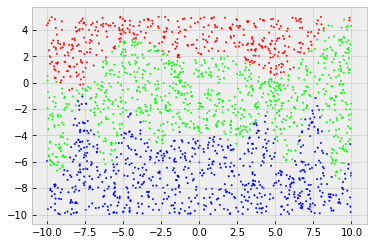

In [1]:
import joblib, tqdm, torch

import numpy as np

from model.classifier import Classifier
from utils.trainer import train
from utils.dataloader import split
from utils.get_labels import label_pts
from utils.generate_data import xmin, xmax, ymin, ymax, b1, b2

import matplotlib.pyplot as plt
plt.style.use('bmh')

# Load data

We define a synthetic dataset with 3 classes over a 2-D feature space.

The boundaries of the dataset can be seen below:

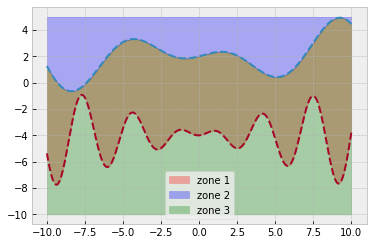

In [2]:
data = joblib.load('data/dataset_init.pt')

x = np.linspace(xmin, xmax, 1000)

bound1 = b1(x)
bound2 = b2(x)

plt.figure()
plt.plot(x, bound1, '--', label='_nolegend_')
plt.plot(x, bound2, '--', label='_nolegend_')

plt.fill_between(x, bound2, bound1, color = 'r', alpha = .3)
plt.fill_between(x, bound1, ymax, color = 'b', alpha = .3)
plt.fill_between(x, ymin, bound1, color='g', alpha=.3)

plt.legend(['zone 1', 'zone 2', 'zone 3'])
plt.show()


Our goal is to learn an accurate classification rule from data that can be sampled in the space.

Let's say we start off with a labeled dataset such as the following :

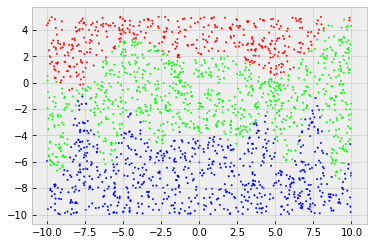

In [3]:
cloud = data['x']
labels = data['y']

plt.figure()
plt.scatter(cloud[:, 0], cloud[:, 1], c = labels, s = 2)
plt.show()

Clearly, this data is not enough to model transition boundaries with high precision, so the goal is to progressivey augment the dataset with samples that are close the boundaries in an Active learning framework.

Let's start with a classical training of the model.

In [4]:
data_train, data_test = split(data, perc = .75)

model = Classifier(input_dim = 2, output_dim = 3).to('cpu')
model.device = 'cpu'
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
criterion = torch.nn.CrossEntropyLoss()

metrics1 = train(model, data_train, data_test, optimizer, criterion, n_epochs = 300, log=50)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
metrics2 = train(model, data_train, data_test, optimizer, criterion, n_epochs = 400, log=50)

metrics = {}
for k in metrics1.keys():
    metrics[k] = np.concatenate((metrics1[k], metrics2[k]))


  0%|          | 1/300 [00:00<01:54,  2.61it/s]

epoch : 0 - L_train : 0.012891723195711772 - L_val : 0.01234504199028015


 17%|█▋        | 51/300 [00:15<01:20,  3.08it/s]

epoch : 50 - L_train : 0.01037841574350993 - L_val : 0.010975804567337035


 34%|███▎      | 101/300 [00:27<00:42,  4.70it/s]

epoch : 100 - L_train : 0.010143429438273111 - L_val : 0.010612154483795166


 50%|█████     | 151/300 [00:38<00:35,  4.22it/s]

epoch : 150 - L_train : 0.010120283126831055 - L_val : 0.010718194961547852


 67%|██████▋   | 201/300 [00:50<00:22,  4.33it/s]

epoch : 200 - L_train : 0.010138279954592386 - L_val : 0.010834911346435546


 84%|████████▎ | 251/300 [01:00<00:11,  4.45it/s]

epoch : 250 - L_train : 0.010387464006741842 - L_val : 0.010765906810760497


  0%|          | 0/400 [00:00<?, ?it/s]

Done training.


  0%|          | 1/400 [00:00<02:36,  2.56it/s]

epoch : 0 - L_train : 0.010206269224484761 - L_val : 0.010578730583190917


 13%|█▎        | 51/400 [00:11<01:14,  4.66it/s]

epoch : 50 - L_train : 0.009937498569488525 - L_val : 0.01054855239391327


 25%|██▌       | 101/400 [00:24<01:02,  4.76it/s]

epoch : 100 - L_train : 0.009929861346880595 - L_val : 0.010553392171859742


 38%|███▊      | 151/400 [00:34<00:51,  4.84it/s]

epoch : 150 - L_train : 0.00995655878384908 - L_val : 0.010553205490112304


 50%|█████     | 201/400 [01:17<01:04,  3.07it/s]

epoch : 200 - L_train : 0.009916020750999451 - L_val : 0.010548010349273681


 63%|██████▎   | 251/400 [01:59<02:19,  1.07it/s]

epoch : 250 - L_train : 0.009948943575223287 - L_val : 0.01056429648399353


 75%|███████▌  | 301/400 [02:23<01:04,  1.54it/s]

epoch : 300 - L_train : 0.009884076436360677 - L_val : 0.010472610473632812


 88%|████████▊ | 351/400 [02:48<00:08,  5.63it/s]

epoch : 350 - L_train : 0.009880688826243083 - L_val : 0.010477139115333557


100%|██████████| 400/400 [02:58<00:00,  2.24it/s]

Done training.


We can clearly see that the model fails to learn the correct boundary, especially since more importance is given to data that is not along the boundaries, which is therefore more numerous and frequent during the training process.

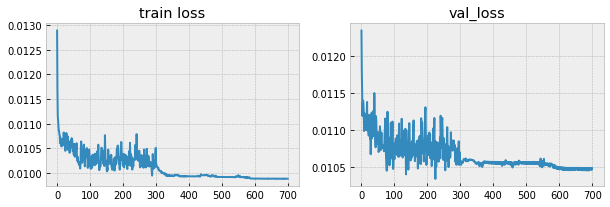

In [5]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))
ax[0].plot(metrics['L_train'])
ax[0].set_title('train loss')

ax[1].plot(metrics['L_val'])
ax[1].set_title('val_loss')
plt.show()

Let's see how well the model is able to separate th different domains.

In [6]:
labels_pred = model(torch.tensor(data_test['x']).float().to(model.device)).detach().numpy()

In [7]:
data_test.keys()

dict_keys(['x', 'y'])

Text(0.5, 1.0, 'predictions')

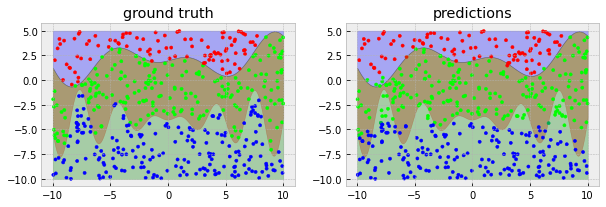

In [8]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[0].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[0].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[0].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = data_test['y'], s = 10)
ax[0].set_title('ground truth')

ax[1].fill_between(x, bound2, bound1, color = 'r', alpha = .3)
ax[1].fill_between(x, bound1, ymax, color = 'b', alpha = .3)
ax[1].fill_between(x, ymin, bound1, color='g', alpha=.3)
ax[1].scatter(data_test['x'][:, 0], data_test['x'][:, 1], c = labels_pred, s =10)
ax[1].set_title('predictions')

In [9]:
n_pts = 20000
cloud = np.random.uniform(low=0, high = 1, size = (n_pts, 2))
cloud[:, 0] = cloud[:, 0]*(xmax - xmin) + xmin
cloud[:, 1] = cloud[:, 1]*(ymax - ymin) + ymin

cloud_pred = model(torch.tensor(cloud).float().to(model.device)).detach().numpy()
cloud_labels = label_pts(cloud)

Text(0.5, 1.0, 'predictions')

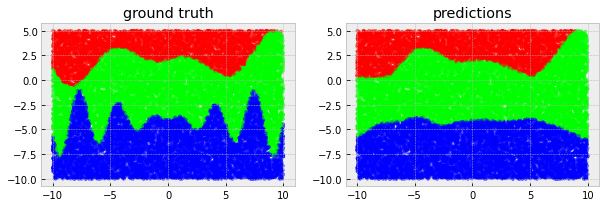

In [12]:
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

ax[0].scatter(cloud[:, 0], cloud[:, 1], c = cloud_labels, s = 10, alpha = .5)
ax[0].set_title('ground truth')

ax[1].scatter(cloud[:, 0], cloud[:, 1], c = cloud_pred, s =10, alpha = .5)
ax[1].set_title('predictions')